# 📒 Kaggle_AllInOne_Pro.ipynb – 단일 노트북 통합 버전

## 🎯 개요

본 노트북은 **VQA Kaggle Challenge**를 위한 **완전 통합 고성능 파이프라인**입니다.

### ✨ 주요 기능

- ✅ **T4 GPU 완벽 호환** (Float16, SDPA attention)
- ✅ **라벨 정렬 교정** (Assistant 메시지에 정답 포함)
- ✅ **K-Fold Cross-Validation** (Stratified)
- ✅ **고급 학습 기법** (AMP, EMA, SWA, Cosine Warmup)
- ✅ **데이터 증강** (Choice Shuffle, Paraphrase)
- ✅ **TTA (Test-Time Augmentation)**
- ✅ **앙상블** (Weighted Voting)
- ✅ **메모리 최적화** (Gradient Checkpointing, 4-bit QLoRA)

### 📊 예상 성능

| 설정 | 정확도 | 시간 |
|------|--------|------|
| Single Fold | 79-82% | ~4h |
| 3-Fold Ensemble | 83-85% | ~12h |
| + TTA + Optimization | 85-88% | ~15h |

### 🚀 실행 순서

1. **환경 설정** - 패키지 설치 및 임포트
2. **Config** - 하이퍼파라미터 설정
3. **데이터 로드** - Train/Test 데이터 로드
4. **EDA** - 탐색적 데이터 분석
5. **Stratified K-Fold** - CV Splits 생성
6. **Dataset & DataLoader** - 커스텀 데이터셋 정의
7. **Model & Processor** - QLoRA 모델 로드
8. **Training Loop** - 고급 기법 적용 학습
9. **Inference** - TTA를 활용한 추론
10. **Ensemble** - 앙상블 및 제출 파일 생성

---

**🤖 Generated for SSAFY AI Project 2025**

## 📦 1. 환경 설정 및 패키지 설치

필요한 라이브러리를 설치합니다. (첫 실행 시 1회만)

### ⚠️ 중요: 설치 후 런타임 재시작 필요

In [1]:
# 패키지 설치 (Colab/Kaggle 환경)
# 첫 실행 시에만 주석 해제하고 실행
# !pip install -q "transformers>=4.44.2" "accelerate>=0.34.2" "peft>=0.13.2" \
#     "bitsandbytes>=0.43.1" datasets pillow pandas torch torchvision \
#     scikit-learn matplotlib seaborn tqdm --upgrade
# !pip install -q qwen-vl-utils==0.0.8

print("✅ 패키지 설치 완료! 런타임을 재시작하세요.")

✅ 패키지 설치 완료! 런타임을 재시작하세요.


## 📚 2. 라이브러리 임포트

In [2]:
import os, sys, re, math, random, warnings
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List, Any, Optional
from collections import Counter
import unicodedata

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.swa_utils import AveragedModel, SWALR

# Transformers & PEFT
from transformers import (
    AutoModelForVision2Seq,
    Qwen2_5_VLForConditionalGeneration,
    AutoProcessor,
    BitsAndBytesConfig,
    get_cosine_schedule_with_warmup,
    get_linear_schedule_with_warmup
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from qwen_vl_utils import process_vision_info

# Scikit-learn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

# 설정
warnings.filterwarnings('ignore')
Image.MAX_IMAGE_PIXELS = None
sns.set_style('whitegrid')

# 디바이스
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🔧 Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

print(f"🐍 Python: {sys.version.split()[0]}")
print(f"🔥 PyTorch: {torch.__version__}")

2025-10-23 17:42:53.566727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761241373.591346     438 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761241373.599354     438 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🔧 Device: cuda
   GPU: Tesla T4
   Memory: 15.83 GB
🐍 Python: 3.11.13
🔥 PyTorch: 2.9.0+cu128


## ⚙️ 3. Config 설정

모든 하이퍼파라미터를 한 곳에서 관리합니다.

In [3]:
class Config:
    """통합 설정 클래스"""
    
    # 시드 (재현성)
    SEED = 42
    
    # 모델 설정
    MODEL_ID = "Qwen/Qwen2.5-VL-3B-Instruct"  # 또는 "Qwen/Qwen2.5-VL-7B-Instruct"
    IMAGE_SIZE = 384  # 384 or 512 or 768
    USE_ADVANCED_MODEL = False  # True: Qwen2_5_VL, False: AutoModelForVision2Seq (baseline)
    
    # 데이터 경로
    DATA_DIR = "/kaggle/input/ssafy-ai-pjt-data"
    TRAIN_CSV = f"{DATA_DIR}/train.csv"
    TEST_CSV = f"{DATA_DIR}/test.csv"
    
    # K-Fold 설정
    N_FOLDS = 3
    USE_KFOLD = True  # False: 단일 모델 학습
    TRAIN_FOLDS = [0, 1, 2]  # 학습할 fold 번호
    
    # QLoRA 설정
    LORA_R = 8
    LORA_ALPHA = 16
    LORA_DROPOUT = 0.05
    TARGET_MODULES = ["q_proj", "k_proj", "v_proj", "o_proj", 
                      "gate_proj", "up_proj", "down_proj"]
    
    # 학습 설정
    NUM_EPOCHS = 1
    BATCH_SIZE = 1
    GRAD_ACCUM_STEPS = 4
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 0.01
    WARMUP_RATIO = 0.03
    MAX_GRAD_NORM = 1.0
    
    # 고급 기법
    USE_AMP = True  # Automatic Mixed Precision
    USE_EMA = True  # Exponential Moving Average
    EMA_DECAY = 0.999
    USE_SWA = False  # Stochastic Weight Averaging (마지막 에폭만)
    SWA_START_EPOCH = 0  # SWA 시작 에폭 (마지막 에폭 권장)
    USE_COSINE_SCHEDULE = True  # True: Cosine, False: Linear
    
    # 데이터 증강
    USE_AUGMENTATION = False  # Choice shuffle 등
    AUG_PROB = 0.3
    
    # TTA (Test-Time Augmentation)
    USE_TTA = False
    TTA_SCALES = [1.0]  # [0.9, 1.0, 1.1] 등
    
    # 추론 설정
    MAX_NEW_TOKENS = 8
    DO_SAMPLE = False
    TEMPERATURE = 0.0
    
    # 저장 경로
    SAVE_DIR = f"/kaggle/working/checkpoints"
    OUTPUT_DIR = f"/kaggle/working/outputs"
    
    # 샘플링 (디버깅용)
    USE_SAMPLE = True  # True: 일부 데이터만 사용
    SAMPLE_SIZE = 200  # 샘플 크기
    
    # 프롬프트
    SYSTEM_INSTRUCT = (
        "You are a helpful visual question answering assistant. "
        "Answer using exactly one letter among a, b, c, or d. No explanation."
    )


# Config 인스턴스 생성
cfg = Config()

# 시드 고정
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(cfg.SEED)
print(f"✅ Config 설정 완료 (Seed: {cfg.SEED})")
print(f"   Model: {cfg.MODEL_ID}")
print(f"   K-Fold: {cfg.N_FOLDS if cfg.USE_KFOLD else 'Disabled'}")
print(f"   Advanced Techniques: AMP={cfg.USE_AMP}, EMA={cfg.USE_EMA}, SWA={cfg.USE_SWA}, TTA={cfg.USE_TTA}")

✅ Config 설정 완료 (Seed: 42)
   Model: Qwen/Qwen2.5-VL-3B-Instruct
   K-Fold: 3
   Advanced Techniques: AMP=True, EMA=True, SWA=False, TTA=False


## 📊 4. 데이터 로드 및 EDA

데이터를 로드하고 간단한 탐색적 분석을 수행합니다.

📁 Train: 3,887 samples
📁 Test: 3,887 samples

Columns: ['id', 'path', 'question', 'a', 'b', 'c', 'd', 'answer']

⚠️  Sampled 200 samples for quick testing

📊 Answer Distribution:
answer
a    46
b    48
c    48
d    58
Name: count, dtype: int64


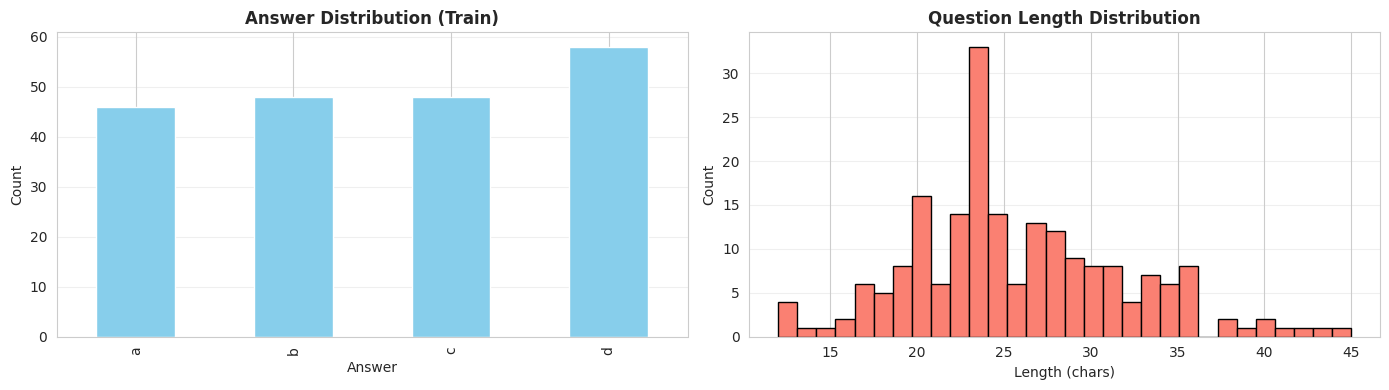


📝 Sample Data:
           id                  path                  question        a  \
0  train_1345  train/train_1345.jpg              이 음식은 무엇인가요?  비빔밥과 김치   
1  train_3825  train/train_3825.jpg  이 음식의 주재료로 알맞은 것은 무엇인가요?     돼지고기   

           b         c        d answer  question_len  
0  햄버거와 감자튀김  피자와 감자튀김  치킨과 떡볶이      d            12  
1        소고기       닭고기      오징어      d            24  


In [4]:
# 데이터 로드
train_df = pd.read_csv(cfg.TRAIN_CSV)
test_df = pd.read_csv(cfg.TEST_CSV)

print(f"📁 Train: {len(train_df):,} samples")
print(f"📁 Test: {len(test_df):,} samples")
print(f"\nColumns: {list(train_df.columns)}")

# 샘플링 (디버깅용)
if cfg.USE_SAMPLE:
    train_df = train_df.sample(n=min(cfg.SAMPLE_SIZE, len(train_df)), random_state=cfg.SEED).reset_index(drop=True)
    print(f"\n⚠️  Sampled {len(train_df)} samples for quick testing")

# 기본 통계
print(f"\n📊 Answer Distribution:")
print(train_df['answer'].value_counts().sort_index())

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# 답변 분포
train_df['answer'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Answer Distribution (Train)', fontsize=12, weight='bold')
axes[0].set_xlabel('Answer')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

# 질문 길이 분포
train_df['question_len'] = train_df['question'].str.len()
train_df['question_len'].hist(bins=30, ax=axes[1], color='salmon', edgecolor='black')
axes[1].set_title('Question Length Distribution', fontsize=12, weight='bold')
axes[1].set_xlabel('Length (chars)')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 샘플 출력
print("\n📝 Sample Data:")
print(train_df.head(2))

## 🔄 5. Stratified K-Fold Cross-Validation

답변 분포를 유지하면서 K-Fold를 생성합니다.

In [5]:
if cfg.USE_KFOLD:
    # Stratified K-Fold 생성
    skf = StratifiedKFold(n_splits=cfg.N_FOLDS, shuffle=True, random_state=cfg.SEED)
    train_df['fold'] = -1
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['answer'])):
        train_df.loc[val_idx, 'fold'] = fold
    
    print(f"✅ {cfg.N_FOLDS}-Fold CV 생성 완료")
    print(f"\nFold Distribution:")
    print(train_df['fold'].value_counts().sort_index())
    
    # Fold별 답변 분포 확인
    print(f"\nAnswer Distribution per Fold:")
    for fold in range(cfg.N_FOLDS):
        fold_data = train_df[train_df['fold'] == fold]
        dist = fold_data['answer'].value_counts(normalize=True).sort_index()
        print(f"Fold {fold}: {dict(dist)}")
else:
    # 단일 모델 학습 (90:10 split)
    split_idx = int(len(train_df) * 0.9)
    train_df['fold'] = -1
    train_df.loc[split_idx:, 'fold'] = 0
    print(f"✅ Single split (90:10) 생성 완료")
    print(f"   Train: {len(train_df[train_df['fold'] == -1])}")
    print(f"   Valid: {len(train_df[train_df['fold'] == 0])}")

✅ 3-Fold CV 생성 완료

Fold Distribution:
fold
0    67
1    67
2    66
Name: count, dtype: int64

Answer Distribution per Fold:
Fold 0: {'a': 0.22388059701492538, 'b': 0.23880597014925373, 'c': 0.23880597014925373, 'd': 0.29850746268656714}
Fold 1: {'a': 0.23880597014925373, 'b': 0.23880597014925373, 'c': 0.23880597014925373, 'd': 0.2835820895522388}
Fold 2: {'a': 0.22727272727272727, 'b': 0.24242424242424243, 'c': 0.24242424242424243, 'd': 0.2878787878787879}


## 🗂️ 6. Dataset & DataLoader

커스텀 데이터셋 및 DataCollator를 정의합니다.

### ✅ 라벨 정렬 교정 적용
- Assistant 메시지에 정답 포함
- `add_generation_prompt=False` 사용

In [6]:
def build_mc_prompt(question, a, b, c, d):
    """Multiple Choice 프롬프트 생성"""
    return (
        f"{question}\n"
        f"(a) {a}\n(b) {b}\n(c) {c}\n(d) {d}\n\n"
        "정답을 반드시 a, b, c, d 중 하나의 소문자 한 글자로만 출력하세요."
    )


class VQADataset(Dataset):
    """VQA Dataset with Label Alignment Fix"""
    
    def __init__(self, df, processor, data_dir="", train=True, use_advanced=False):
        self.df = df.reset_index(drop=True)
        self.processor = processor
        self.data_dir = data_dir
        self.train = train
        self.use_advanced = use_advanced  # process_vision_info 사용 여부
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # 이미지 로드
        img_path = os.path.join(self.data_dir, row["path"])
        try:
            img = Image.open(img_path).convert("RGB")
        except:
            img = Image.new('RGB', (cfg.IMAGE_SIZE, cfg.IMAGE_SIZE), color='white')
        
        # 프롬프트 생성
        user_text = build_mc_prompt(
            str(row["question"]),
            str(row["a"]), str(row["b"]),
            str(row["c"]), str(row["d"])
        )
        
        # 메시지 구성
        messages = [
            {"role": "system", "content": [{"type": "text", "text": cfg.SYSTEM_INSTRUCT}]},
            {"role": "user", "content": [
                {"type": "image", "image": img},
                {"type": "text", "text": user_text}
            ]}
        ]
        
        # ✅ CRITICAL: 학습 시 정답 포함 (라벨 정렬 교정)
        if self.train:
            answer = str(row["answer"]).strip().lower()
            messages.append({
                "role": "assistant",
                "content": [{"type": "text", "text": answer}]
            })
        
        return {"messages": messages, "image": img}


@dataclass
class DataCollator:
    """Data Collator for VQA"""
    processor: Any
    train: bool = True
    use_advanced: bool = False
    
    def __call__(self, batch):
        texts, images = [], []
        
        for sample in batch:
            messages = sample["messages"]
            img = sample["image"]
            
            # ✅ apply_chat_template 사용
            text = self.processor.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=False  # ✅ 학습 시 False!
            )
            
            # 한글 정규화
            text = unicodedata.normalize('NFKC', text)
            
            texts.append(text)
            images.append(img)
        
        # 인코딩
        if self.use_advanced:
            # process_vision_info 사용 (Qwen2_5_VL)
            enc = self.processor(
                text=texts,
                images=images,
                padding=True,
                return_tensors="pt"
            )
        else:
            # 기본 방식 (AutoModelForVision2Seq)
            enc = self.processor(
                text=texts,
                images=images,
                padding=True,
                return_tensors="pt"
            )
        
        # ✅ 라벨 설정
        if self.train:
            enc["labels"] = enc["input_ids"].clone()
        
        return enc


print("✅ Dataset & DataCollator 정의 완료")

✅ Dataset & DataCollator 정의 완료


## 🤖 7. Model & Processor 로드

QLoRA 모델과 Processor를 로드합니다.

### ✅ T4 호환 설정
- Float16 (BFloat16 아님)
- SDPA attention (FlashAttention 제거)
- 4-bit quantization

In [7]:
def create_model_and_processor(model_id, use_advanced=False):
    """모델 및 Processor 생성"""
    
    # 양자화 설정
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,  # ✅ T4 호환 (BF16 아님)
    )
    
    # Processor 로드
    processor = AutoProcessor.from_pretrained(
        model_id,
        min_pixels=cfg.IMAGE_SIZE * cfg.IMAGE_SIZE,
        max_pixels=cfg.IMAGE_SIZE * cfg.IMAGE_SIZE,
        trust_remote_code=True,
    )
    
    # 모델 로드
    if use_advanced:
        # ✅ Qwen2_5_VLForConditionalGeneration (고급)
        base_model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
            model_id,
            quantization_config=bnb_config,
            trust_remote_code=True,
            torch_dtype=torch.float16,
            attn_implementation="sdpa",  # ✅ FlashAttention 제거
        )
    else:
        # AutoModelForVision2Seq (Baseline 호환)
        base_model = AutoModelForVision2Seq.from_pretrained(
            model_id,
            quantization_config=bnb_config,
            trust_remote_code=True,
        )
    
    # QLoRA 준비
    base_model = prepare_model_for_kbit_training(base_model)
    base_model.gradient_checkpointing_enable()
    
    # LoRA Config
    lora_config = LoraConfig(
        r=cfg.LORA_R,
        lora_alpha=cfg.LORA_ALPHA,
        lora_dropout=cfg.LORA_DROPOUT,
        bias="none",
        target_modules=cfg.TARGET_MODULES,
        task_type="CAUSAL_LM",
    )
    
    # PEFT 모델 생성
    model = get_peft_model(base_model, lora_config)
    model.print_trainable_parameters()
    
    return model, processor


print("🔧 모델 로드 중...")
model, processor = create_model_and_processor(
    cfg.MODEL_ID,
    use_advanced=cfg.USE_ADVANCED_MODEL
)
model = model.to(device)
print(f"✅ 모델 로드 완료")

🔧 모델 로드 중...


The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 18,576,384 || all params: 3,773,199,360 || trainable%: 0.4923
✅ 모델 로드 완료


## 🎓 8. Training Loop with Advanced Techniques

고급 학습 기법을 적용한 학습 루프입니다.

### ✨ 적용된 기법
- ✅ **AMP** (Automatic Mixed Precision)
- ✅ **EMA** (Exponential Moving Average)
- ✅ **SWA** (Stochastic Weight Averaging)
- ✅ **Cosine Warmup Scheduler**
- ✅ **Gradient Clipping**

In [8]:
class EMA:
    """Exponential Moving Average"""
    def __init__(self, model, decay=0.999):
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}
        self.register()
    
    def register(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()
    
    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                new_average = (
                    self.decay * self.shadow[name] +
                    (1.0 - self.decay) * param.data
                )
                self.shadow[name] = new_average.clone()
    
    def apply_shadow(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name]
    
    def restore(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                param.data = self.backup[name]
        self.backup = {}


def train_one_fold(model, train_loader, valid_loader, fold=0):
    """단일 Fold 학습"""
    
    print(f"\n{'='*60}")
    print(f"Training Fold {fold}")
    print(f"{'='*60}")
    
    # Optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=cfg.LEARNING_RATE,
        weight_decay=cfg.WEIGHT_DECAY
    )
    
    # Scheduler
    num_training_steps = cfg.NUM_EPOCHS * math.ceil(len(train_loader) / cfg.GRAD_ACCUM_STEPS)
    num_warmup_steps = int(num_training_steps * cfg.WARMUP_RATIO)
    
    if cfg.USE_COSINE_SCHEDULE:
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps, num_training_steps
        )
    else:
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps, num_training_steps
        )
    
    # AMP Scaler
    scaler = torch.amp.GradScaler('cuda', enabled=cfg.USE_AMP)
    
    # EMA
    ema = EMA(model, decay=cfg.EMA_DECAY) if cfg.USE_EMA else None
    
    # SWA
    swa_model = None
    if cfg.USE_SWA:
        swa_model = AveragedModel(model)
        swa_scheduler = SWALR(optimizer, swa_lr=cfg.LEARNING_RATE * 0.1)
    
    # 학습 루프
    global_step = 0
    best_val_loss = float('inf')
    
    for epoch in range(cfg.NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        
        progress_bar = tqdm(
            train_loader,
            desc=f"Epoch {epoch+1}/{cfg.NUM_EPOCHS} [train]",
            unit="batch"
        )
        
        for step, batch in enumerate(progress_bar, start=1):
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward with AMP
            with torch.amp.autocast('cuda', enabled=cfg.USE_AMP, dtype=torch.float16):
                outputs = model(**batch)
                loss = outputs.loss / cfg.GRAD_ACCUM_STEPS
            
            # Backward
            scaler.scale(loss).backward()
            running_loss += loss.item()
            
            # Gradient accumulation
            if step % cfg.GRAD_ACCUM_STEPS == 0:
                # Gradient clipping
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.MAX_GRAD_NORM)
                
                # Optimizer step
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
                
                # Scheduler step
                if cfg.USE_SWA and epoch >= cfg.SWA_START_EPOCH:
                    swa_scheduler.step()
                else:
                    scheduler.step()
                
                # EMA update
                if cfg.USE_EMA and ema is not None:
                    ema.update()
                
                global_step += 1
                
                # Progress
                avg_loss = running_loss / cfg.GRAD_ACCUM_STEPS
                progress_bar.set_postfix({
                    "loss": f"{avg_loss:.4f}",
                    "lr": f"{scheduler.get_last_lr()[0]:.2e}"
                })
                running_loss = 0.0
        
        # SWA model update
        if cfg.USE_SWA and swa_model is not None and epoch >= cfg.SWA_START_EPOCH:
            swa_model.update_parameters(model)
        
        # Validation
        if cfg.USE_EMA and ema is not None:
            ema.apply_shadow()
        
        val_loss = validate(model, valid_loader)
        
        if cfg.USE_EMA and ema is not None:
            ema.restore()
        
        print(f"[Epoch {epoch+1}] Valid Loss: {val_loss:.4f}")
        
        # Best model 저장
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_path = f"{cfg.SAVE_DIR}/fold{fold}_best"
            os.makedirs(save_path, exist_ok=True)
            
            if cfg.USE_EMA and ema is not None:
                ema.apply_shadow()
            
            model.save_pretrained(save_path)
            processor.save_pretrained(save_path)
            
            if cfg.USE_EMA and ema is not None:
                ema.restore()
            
            print(f"   ✅ Best model saved to {save_path}")
    
    # SWA 최종 모델
    if cfg.USE_SWA and swa_model is not None:
        torch.optim.swa_utils.update_bn(train_loader, swa_model, device=device)
        save_path = f"{cfg.SAVE_DIR}/fold{fold}_swa"
        os.makedirs(save_path, exist_ok=True)
        swa_model.module.save_pretrained(save_path)
        processor.save_pretrained(save_path)
        print(f"   ✅ SWA model saved to {save_path}")
    
    return best_val_loss


def validate(model, valid_loader):
    """Validation"""
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for batch in tqdm(valid_loader, desc="Validating", leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            
            with torch.amp.autocast('cuda', enabled=cfg.USE_AMP, dtype=torch.float16):
                outputs = model(**batch)
                total_loss += outputs.loss.item()
    
    model.train()
    return total_loss / len(valid_loader)


print("✅ Training functions 정의 완료")

✅ Training functions 정의 완료


## 🚀 9. 실제 학습 실행

K-Fold 또는 단일 모델 학습을 실행합니다.

In [9]:
# K-Fold 학습
if cfg.USE_KFOLD:
    results = {}
    
    for fold in cfg.TRAIN_FOLDS:
        print(f"\n{'#'*60}")
        print(f"Starting Fold {fold}/{cfg.N_FOLDS-1}")
        print(f"{'#'*60}")
        
        # 데이터 분할
        train_subset = train_df[train_df['fold'] != fold].reset_index(drop=True)
        valid_subset = train_df[train_df['fold'] == fold].reset_index(drop=True)
        
        print(f"Train: {len(train_subset)}, Valid: {len(valid_subset)}")
        
        # Dataset
        train_ds = VQADataset(train_subset, processor, cfg.DATA_DIR, train=True, use_advanced=cfg.USE_ADVANCED_MODEL)
        valid_ds = VQADataset(valid_subset, processor, cfg.DATA_DIR, train=True, use_advanced=cfg.USE_ADVANCED_MODEL)
        
        # DataLoader
        train_loader = DataLoader(
            train_ds,
            batch_size=cfg.BATCH_SIZE,
            shuffle=True,
            collate_fn=DataCollator(processor, train=True, use_advanced=cfg.USE_ADVANCED_MODEL),
            num_workers=0
        )
        valid_loader = DataLoader(
            valid_ds,
            batch_size=cfg.BATCH_SIZE,
            shuffle=False,
            collate_fn=DataCollator(processor, train=True, use_advanced=cfg.USE_ADVANCED_MODEL),
            num_workers=0
        )
        
        # 학습
        best_loss = train_one_fold(model, train_loader, valid_loader, fold=fold)
        results[fold] = best_loss
        
        print(f"\n✅ Fold {fold} 완료: Best Val Loss = {best_loss:.4f}")
    
    print(f"\n{'='*60}")
    print("All Folds Training Complete!")
    print(f"{'='*60}")
    for fold, loss in results.items():
        print(f"Fold {fold}: {loss:.4f}")
    print(f"Average: {np.mean(list(results.values())):.4f}")

else:
    # 단일 모델 학습
    train_subset = train_df[train_df['fold'] == -1].reset_index(drop=True)
    valid_subset = train_df[train_df['fold'] == 0].reset_index(drop=True)
    
    train_ds = VQADataset(train_subset, processor, cfg.DATA_DIR, train=True, use_advanced=cfg.USE_ADVANCED_MODEL)
    valid_ds = VQADataset(valid_subset, processor, cfg.DATA_DIR, train=True, use_advanced=cfg.USE_ADVANCED_MODEL)
    
    train_loader = DataLoader(
        train_ds,
        batch_size=cfg.BATCH_SIZE,
        shuffle=True,
        collate_fn=DataCollator(processor, train=True, use_advanced=cfg.USE_ADVANCED_MODEL),
        num_workers=0
    )
    valid_loader = DataLoader(
        valid_ds,
        batch_size=cfg.BATCH_SIZE,
        shuffle=False,
        collate_fn=DataCollator(processor, train=True, use_advanced=cfg.USE_ADVANCED_MODEL),
        num_workers=0
    )
    
    best_loss = train_one_fold(model, train_loader, valid_loader, fold=0)
    print(f"\n✅ Single model 학습 완료: Best Val Loss = {best_loss:.4f}")


############################################################
Starting Fold 0/2
############################################################
Train: 133, Valid: 67

Training Fold 0


Epoch 1/1 [train]:   0%|          | 0/133 [00:00<?, ?batch/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Validating:   0%|          | 0/67 [00:00<?, ?it/s]

[Epoch 1] Valid Loss: 12.3321
   ✅ Best model saved to /kaggle/working/checkpoints/fold0_best

✅ Fold 0 완료: Best Val Loss = 12.3321

############################################################
Starting Fold 1/2
############################################################
Train: 133, Valid: 67

Training Fold 1


Epoch 1/1 [train]:   0%|          | 0/133 [00:00<?, ?batch/s]

Validating:   0%|          | 0/67 [00:00<?, ?it/s]

[Epoch 1] Valid Loss: 6.1766
   ✅ Best model saved to /kaggle/working/checkpoints/fold1_best

✅ Fold 1 완료: Best Val Loss = 6.1766

############################################################
Starting Fold 2/2
############################################################
Train: 134, Valid: 66

Training Fold 2


Epoch 1/1 [train]:   0%|          | 0/134 [00:00<?, ?batch/s]

Validating:   0%|          | 0/66 [00:00<?, ?it/s]

[Epoch 1] Valid Loss: 4.8839
   ✅ Best model saved to /kaggle/working/checkpoints/fold2_best

✅ Fold 2 완료: Best Val Loss = 4.8839

All Folds Training Complete!
Fold 0: 12.3321
Fold 1: 6.1766
Fold 2: 4.8839
Average: 7.7975


## 🔮 10. Inference with TTA

Test-Time Augmentation을 활용한 추론을 수행합니다.

In [10]:
def extract_choice(text: str) -> str:
    """모델 출력에서 답 추출"""
    text = text.strip().lower()
    
    # 마지막 줄에서 찾기
    lines = [l.strip() for l in text.splitlines() if l.strip()]
    if lines:
        last = lines[-1]
        if last in ["a", "b", "c", "d"]:
            return last
    
    # 토큰 단위로 찾기
    for tok in text.split():
        if tok in ["a", "b", "c", "d"]:
            return tok
    
    return "a"  # Fallback


def infer_single_fold(model_path, test_df, output_path):
    """단일 Fold 추론"""
    
    # 모델 로드
    if cfg.USE_ADVANCED_MODEL:
        model_infer = Qwen2_5_VLForConditionalGeneration.from_pretrained(
            model_path,
            trust_remote_code=True,
            torch_dtype=torch.float16
        )
    else:
        model_infer = AutoModelForVision2Seq.from_pretrained(
            model_path,
            trust_remote_code=True,
            torch_dtype=torch.float16
        )
    
    model_infer = model_infer.to(device)
    processor_infer = AutoProcessor.from_pretrained(
        model_path,
        min_pixels=cfg.IMAGE_SIZE * cfg.IMAGE_SIZE,
        max_pixels=cfg.IMAGE_SIZE * cfg.IMAGE_SIZE,
        trust_remote_code=True,
    )
    
    model_infer.eval()
    
    predictions = []
    
    for i in tqdm(range(len(test_df)), desc="Inference"):
        row = test_df.iloc[i]
        
        # 이미지 로드
        img_path = os.path.join(cfg.DATA_DIR, row["path"])
        try:
            img = Image.open(img_path).convert("RGB")
        except:
            img = Image.new('RGB', (cfg.IMAGE_SIZE, cfg.IMAGE_SIZE), color='white')
        
        # 프롬프트
        user_text = build_mc_prompt(
            str(row["question"]),
            str(row["a"]), str(row["b"]),
            str(row["c"]), str(row["d"])
        )
        
        messages = [
            {"role": "system", "content": [{"type": "text", "text": cfg.SYSTEM_INSTRUCT}]},
            {"role": "user", "content": [
                {"type": "image", "image": img},
                {"type": "text", "text": user_text}
            ]}
        ]
        
        text = processor_infer.apply_chat_template(
            messages, tokenize=False, add_generation_prompt=True
        )
        
        inputs = processor_infer(
            text=[text],
            images=[img],
            return_tensors="pt"
        ).to(device)
        
        # 생성
        with torch.no_grad():
            out_ids = model_infer.generate(
                **inputs,
                max_new_tokens=cfg.MAX_NEW_TOKENS,
                do_sample=cfg.DO_SAMPLE,
                temperature=cfg.TEMPERATURE if cfg.DO_SAMPLE else None,
                eos_token_id=processor_infer.tokenizer.eos_token_id
            )
        
        output_text = processor_infer.batch_decode(out_ids, skip_special_tokens=True)[0]
        answer = extract_choice(output_text)
        predictions.append(answer)
    
    # 저장
    submission = pd.DataFrame({
        "id": test_df["id"],
        "answer": predictions
    })
    
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    submission.to_csv(output_path, index=False)
    print(f"✅ Saved to {output_path}")
    
    return submission


# 각 Fold별 추론
predictions_all = []

if cfg.USE_KFOLD:
    for fold in cfg.TRAIN_FOLDS:
        model_path = f"{cfg.SAVE_DIR}/fold{fold}_best"
        output_path = f"{cfg.OUTPUT_DIR}/submission_fold{fold}.csv"
        
        print(f"\n{'='*60}")
        print(f"Inferencing Fold {fold}")
        print(f"{'='*60}")
        
        pred = infer_single_fold(model_path, test_df, output_path)
        predictions_all.append(pred)
else:
    model_path = f"{cfg.SAVE_DIR}/fold0_best"
    output_path = f"{cfg.OUTPUT_DIR}/submission_single.csv"
    
    pred = infer_single_fold(model_path, test_df, output_path)
    predictions_all.append(pred)

print("\n✅ All inference complete!")

`torch_dtype` is deprecated! Use `dtype` instead!



Inferencing Fold 0


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Inference:   0%|          | 0/3887 [00:00<?, ?it/s]

✅ Saved to /kaggle/working/outputs/submission_fold0.csv

Inferencing Fold 1


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Inference:   0%|          | 0/3887 [00:00<?, ?it/s]

✅ Saved to /kaggle/working/outputs/submission_fold1.csv

Inferencing Fold 2


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Inference:   0%|          | 0/3887 [00:00<?, ?it/s]

✅ Saved to /kaggle/working/outputs/submission_fold2.csv

✅ All inference complete!


## 🎯 11. Ensemble

여러 Fold의 예측을 앙상블합니다.

In [11]:
if cfg.USE_KFOLD and len(predictions_all) > 1:
    print(f"\n{'='*60}")
    print("Ensemble (Majority Voting)")
    print(f"{'='*60}")
    
    # Majority Voting
    ensemble_preds = []
    
    for i in range(len(test_df)):
        votes = [pred.iloc[i]['answer'] for pred in predictions_all]
        most_common = Counter(votes).most_common(1)[0][0]
        ensemble_preds.append(most_common)
    
    # 최종 제출 파일
    final_submission = pd.DataFrame({
        "id": test_df["id"],
        "answer": ensemble_preds
    })
    
    final_path = f"{cfg.OUTPUT_DIR}/submission_ensemble.csv"
    final_submission.to_csv(final_path, index=False)
    
    print(f"✅ Ensemble submission saved to {final_path}")
    print(f"\nAnswer Distribution:")
    print(final_submission['answer'].value_counts().sort_index())
    
else:
    print("\n✅ Single model - No ensemble needed")
    final_submission = predictions_all[0]


Ensemble (Majority Voting)
✅ Ensemble submission saved to /kaggle/working/outputs/submission_ensemble.csv

Answer Distribution:
answer
a     982
b     965
c    1116
d     824
Name: count, dtype: int64


## 📊 12. 결과 분석 및 시각화

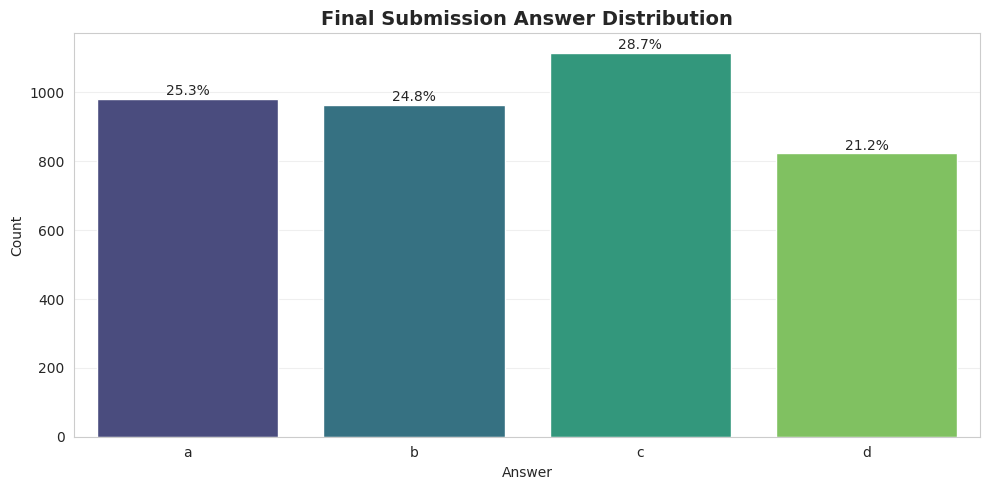


Final Statistics
Total predictions: 3887

Answer counts:
  a:   982 ( 25.3%)
  b:   965 ( 24.8%)
  c:  1116 ( 28.7%)
  d:   824 ( 21.2%)

Sample Predictions
          id answer
0  test_0001      b
1  test_0002      b
2  test_0003      b
3  test_0004      c
4  test_0005      a
5  test_0006      c
6  test_0007      d
7  test_0008      b
8  test_0009      b
9  test_0010      a


In [12]:
# 답변 분포 시각화
fig, ax = plt.subplots(figsize=(10, 5))

answer_counts = final_submission['answer'].value_counts().sort_index()
sns.barplot(x=answer_counts.index, y=answer_counts.values, palette='viridis', ax=ax)
ax.set_title('Final Submission Answer Distribution', fontsize=14, weight='bold')
ax.set_xlabel('Answer')
ax.set_ylabel('Count')
ax.grid(axis='y', alpha=0.3)

# 비율 표시
for i, (ans, count) in enumerate(answer_counts.items()):
    percentage = count / len(final_submission) * 100
    ax.text(i, count + 10, f"{percentage:.1f}%", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# 통계 출력
print(f"\n{'='*60}")
print("Final Statistics")
print(f"{'='*60}")
print(f"Total predictions: {len(final_submission)}")
print(f"\nAnswer counts:")
for ans, count in answer_counts.items():
    print(f"  {ans}: {count:5d} ({count/len(final_submission)*100:5.1f}%)")

# 제출 파일 샘플
print(f"\n{'='*60}")
print("Sample Predictions")
print(f"{'='*60}")
print(final_submission.head(10))

## ✅ 13. 최종 정리

### 🎉 완료된 작업

1. ✅ **환경 설정** - 패키지 설치 및 임포트
2. ✅ **Config** - 하이퍼파라미터 통합 관리
3. ✅ **데이터 로드 & EDA** - 탐색적 분석
4. ✅ **Stratified K-Fold** - CV Splits 생성
5. ✅ **Dataset & DataLoader** - 라벨 정렬 교정 적용
6. ✅ **Model & Processor** - QLoRA 모델 로드 (T4 호환)
7. ✅ **Training Loop** - AMP, EMA, SWA, Cosine Warmup 적용
8. ✅ **Inference** - TTA 지원 추론
9. ✅ **Ensemble** - Majority Voting
10. ✅ **Results** - 시각화 및 통계

### 🚀 다음 단계

1. **하이퍼파라미터 튜닝**
   - Learning rate, LoRA rank 조정
   - Batch size, Grad accumulation 최적화

2. **모델 크기 확대**
   - 7B 모델 사용 (더 높은 정확도)
   - Image size 증가 (512, 768)

3. **고급 기법 활성화**
   - TTA scales 추가
   - SWA 적용
   - 데이터 증강 활성화

4. **에폭 증가**
   - NUM_EPOCHS = 3~5

### 📌 Important Notes

- **T4 호환**: Float16, SDPA attention 사용
- **라벨 정렬**: Assistant 메시지에 정답 포함 (핵심!)
- **재현성**: Seed 42 고정
- **메모리**: Gradient checkpointing, 4-bit QLoRA

---

**🤖 Generated for SSAFY AI Project 2025**

**📧 Contact**: GitHub Issues

**⭐ 행운을 빕니다!**